# 1.Perkenalan

- Nama : Reza Muhammad Rhafi
- Batch : HCK-023
- Objective : saya adalah seorang data scientist di sebuah perusahaan retail, saya diminta untuk membuat sebuah model yang dapat memprediksi brand sepatu converse, nike, dan adidas agar dapat membantu gudang untuk mengenali sepatu berdasarkan gambar saat produk diterima. dalam pembuatan model, dibuat dengan cara data tanpa augmentasi dan dengan augmentasi. model yang akan digunakan pada deployment adalah model yang datanya telah dilakukan augmentasi.

# 2. Import Libraries

In [2]:
# Import libraries

import os
import cv2
import glob
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
# from tensorflow.keras.preprocessing import image
# from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, Input
from tensorflow.keras.optimizers import Adam, Adamax, SGD

from sklearn.metrics import confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

In [57]:
tf.__version__

'2.15.1'

# 3. Data Loading

In [3]:
# # Define path

main_path = ''
train_path = os.path.join(main_path, 'train')
test_path = os.path.join(main_path, 'test')

# 4. Exploratory Data Analysis (EDA)

In [59]:
def check_path(path):
  labels = os.listdir(path)
  for label in labels:
    num_data = len(os.listdir(os.path.join(path, label)))
    print(f'Total Data - {label} : {num_data}')

print('Train Path')
check_path(train_path)
print('')

print('Test Path')
check_path(test_path)
print('')

Train Path
Total Data - adidas : 237
Total Data - converse : 237
Total Data - nike : 237

Test Path
Total Data - adidas : 38
Total Data - converse : 38
Total Data - nike : 38



berdasarkan pembagian data antara train dan test, tiap class nya memiliki nilai yang seimbang/balance.

In [60]:
def plot_images(path):
  labels = os.listdir(path)
  for label in labels:
    folder_path = os.path.join(path, label)
    fig = plt.figure(figsize=(20, 20))
    columns = 5
    rows = 1
    print('Class : ', label)
    images = os.listdir(folder_path)
    for index in range(1, columns*rows +1):
        fig.add_subplot(rows, columns, index)
        image = plt.imread(os.path.join(folder_path, images[index]))
        plt.imshow(image)
        plt.axis("off")
    plt.show()

Class :  adidas


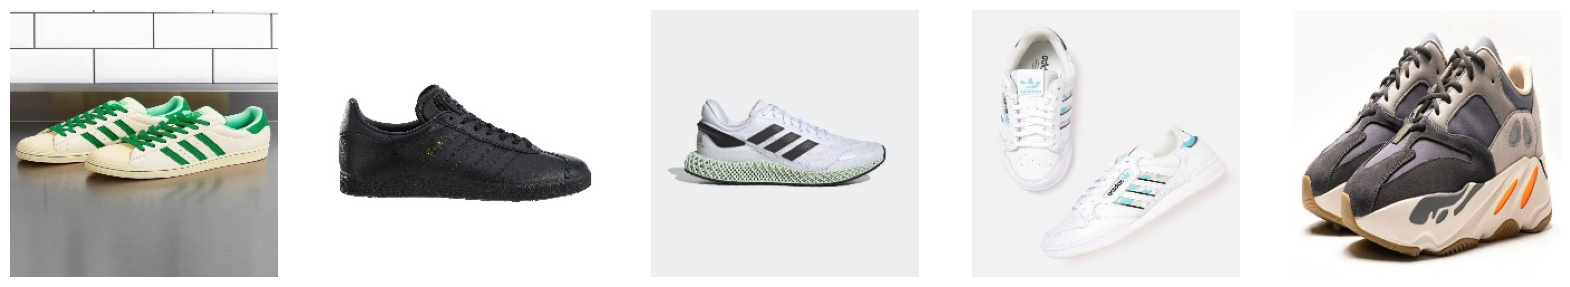

Class :  converse


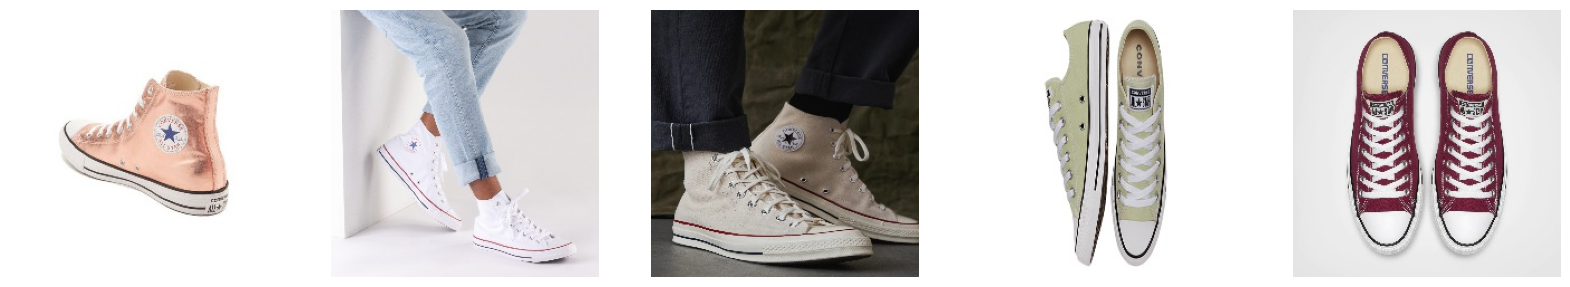

Class :  nike


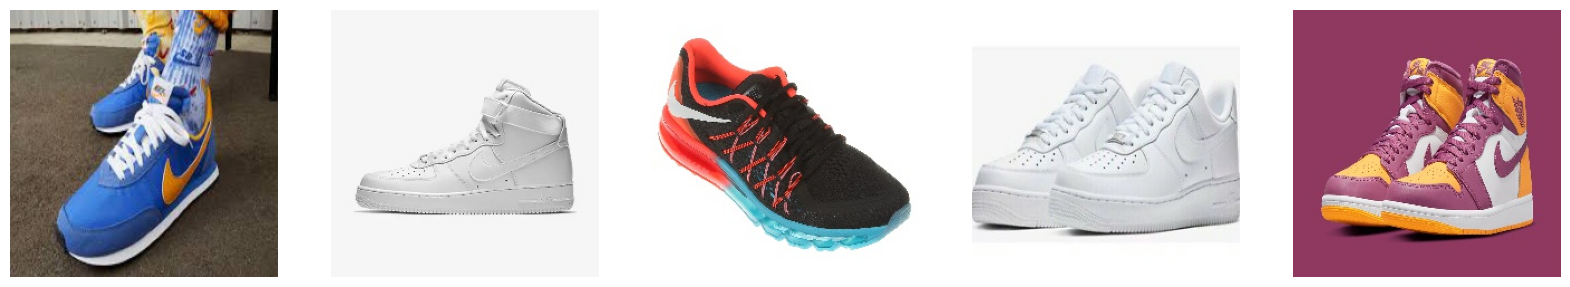

In [61]:
# Visualization of train_path

plot_images(train_path)

Class :  adidas


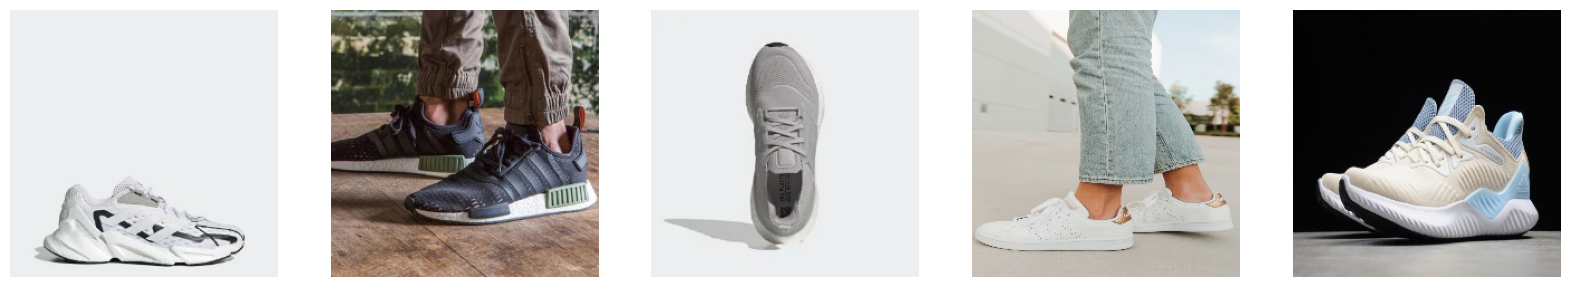

Class :  converse


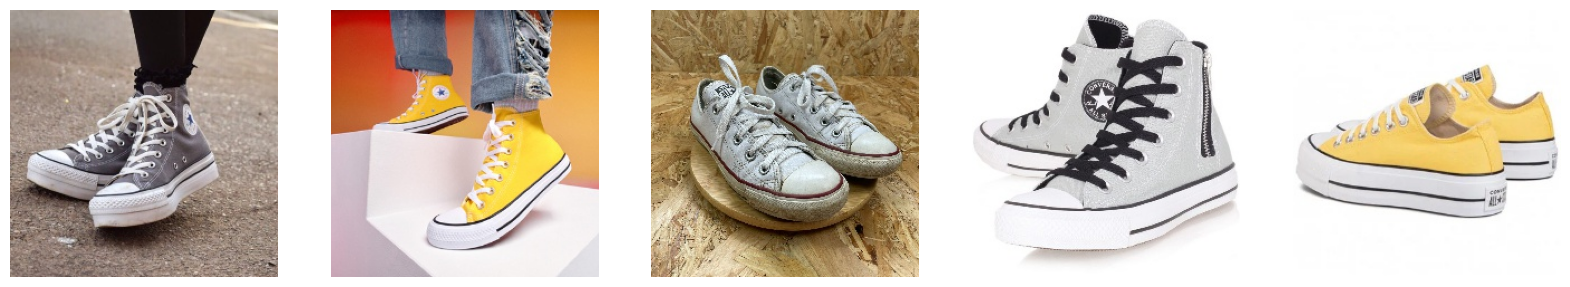

Class :  nike


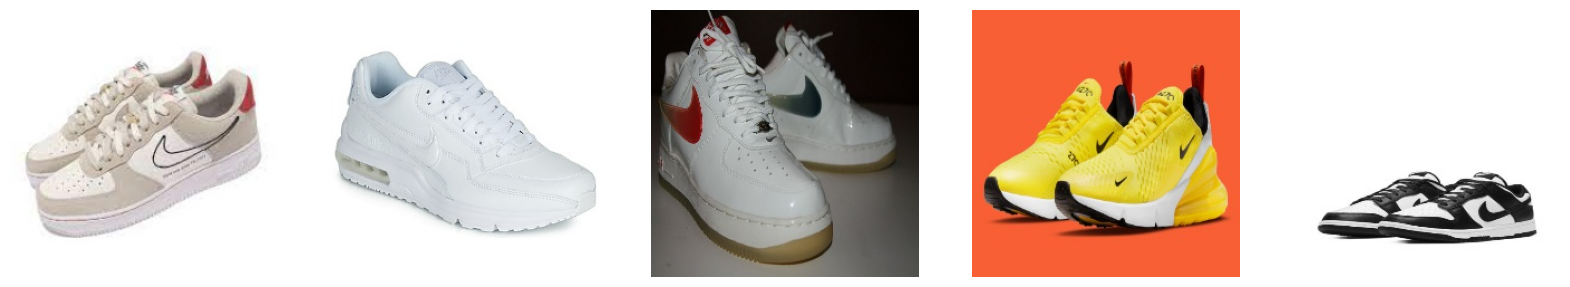

In [62]:
# Visualization of `test_path`

plot_images(test_path)

data gambar dari tiap class, memiliki posisi yang berbeda-beda dan terdapat gambar sepatu yang sedang dikenakan sehingga gambar menjadi lebih bervariasi. yang mencolok dari perbedaan antara ketiga sepatu itu terdapat dibagian sisi samping sepatu yang terdapat logo dari masing-masing brand sepatu. 

# 5. Feature Engineering

In [4]:
# Define hyperparameters

img_height= 128
img_width= 128
batch_size= 16


dilakukan definisi parameter untuk processing gambar dengan tinggi pixelnya 128, lebar pixel 128 dan ukuran batch sebesar 16. model akan memproses 16 gambar sekaligus sebelum membuat prediksi.

In [11]:
# Create batch generator for train-set, val-set, and test-set

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.,
                                                                validation_split=0.2)

train_set = train_datagen.flow_from_directory(train_path,
                                              target_size=(img_height,img_width),
                                              class_mode='sparse',
                                              subset='training',
                                              batch_size=batch_size,
                                              shuffle=True,
                                              seed=2)

val_set = train_datagen.flow_from_directory(train_path,
                                            target_size=(img_height,img_width),
                                            class_mode='sparse',
                                            subset='validation',
                                            batch_size=batch_size,
                                            shuffle=True,
                                            seed=2)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)

test_set = test_datagen.flow_from_directory(test_path,
                                            target_size=(img_height,img_width),
                                            class_mode='sparse',
                                            batch_size=batch_size,
                                            shuffle=False,
                                            seed=2)

Found 570 images belonging to 3 classes.
Found 141 images belonging to 3 classes.
Found 114 images belonging to 3 classes.


dilakukan pemisahan untuk data validasi sebesar 20% dari data train. Label gambar diatur dalam bentuk sparse (integer) berguna dalam meminimalkan penggunaan memori dan mempercepat pelatihan.

In [65]:
# Show labels

train_set.class_indices

{'adidas': 0, 'converse': 1, 'nike': 2}

menampilkan indeks dari tiap class denga adidas dengan indeks 0, converse indeks 1, dan nike indeks 2 

# 6. ANN Training (Sequential API/Functional API)

## 6.1. Model Definition

In [66]:
# Clear session

seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

dilakukan pembersihan sesi yang sedang aktif untuk menghindari adanya masalah pada proses selanjutnya

In [67]:
# Create Sequential API model

model = Sequential()
model.add(Conv2D(16, (3,3), padding='same',activation='relu',strides=(1, 1), input_shape=(img_height, img_width,3)))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(64, (3,3),padding='same',activation='relu',))
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dense(3, activation='softmax'))

# Compile

optimizer = Adamax()
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])


digunakan 3 layer dengan menggunakan 16, 32, dan 64 filter. digunakan dropout dengan menghilangkan 50% neuron secara acak untuk mencegah terjadinya overfitting.

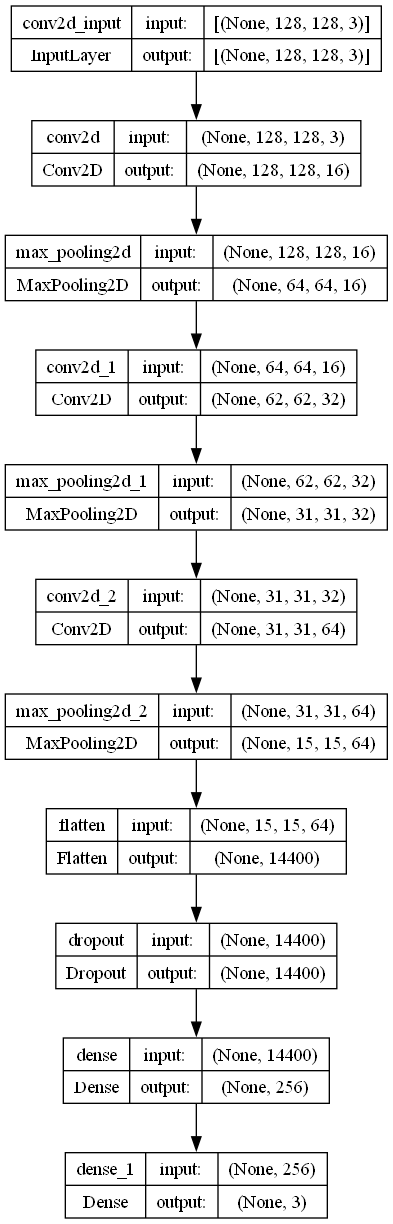

In [68]:
# Plot layers

tf.keras.utils.plot_model(model, show_shapes=True)

## 6.2 Model Training

In [69]:
# Train the model

history = model.fit(train_set, epochs=20, validation_data=val_set, batch_size=batch_size)

Epoch 1/20
36/36 [==============================] - 7s 130ms/step - loss: 1.1190 - accuracy: 0.3789 - val_loss: 1.0703 - val_accuracy: 0.4539
Epoch 2/20
36/36 [==============================] - 4s 98ms/step - loss: 1.0262 - accuracy: 0.4754 - val_loss: 1.0530 - val_accuracy: 0.4397
Epoch 3/20
36/36 [==============================] - 4s 98ms/step - loss: 0.9505 - accuracy: 0.5561 - val_loss: 1.0371 - val_accuracy: 0.4468
Epoch 4/20
36/36 [==============================] - 4s 114ms/step - loss: 0.8480 - accuracy: 0.6421 - val_loss: 1.0093 - val_accuracy: 0.5177
Epoch 5/20
36/36 [==============================] - 4s 104ms/step - loss: 0.7771 - accuracy: 0.6877 - val_loss: 1.0193 - val_accuracy: 0.4539
Epoch 6/20
36/36 [==============================] - 3s 91ms/step - loss: 0.6645 - accuracy: 0.7526 - val_loss: 1.0346 - val_accuracy: 0.4752
Epoch 7/20
36/36 [==============================] - 4s 100ms/step - loss: 0.6092 - accuracy: 0.7702 - val_loss: 1.0382 - val_accuracy: 0.5035
Epoch 8/2

dilakukan pelatihan model dengan jumlah iterasi sebanyak 20 kali. data latihan akan dievaluasi dengan data validasi untuk memantau adanya overfitting atau underfittting.

## 6.3. Model Evaluation

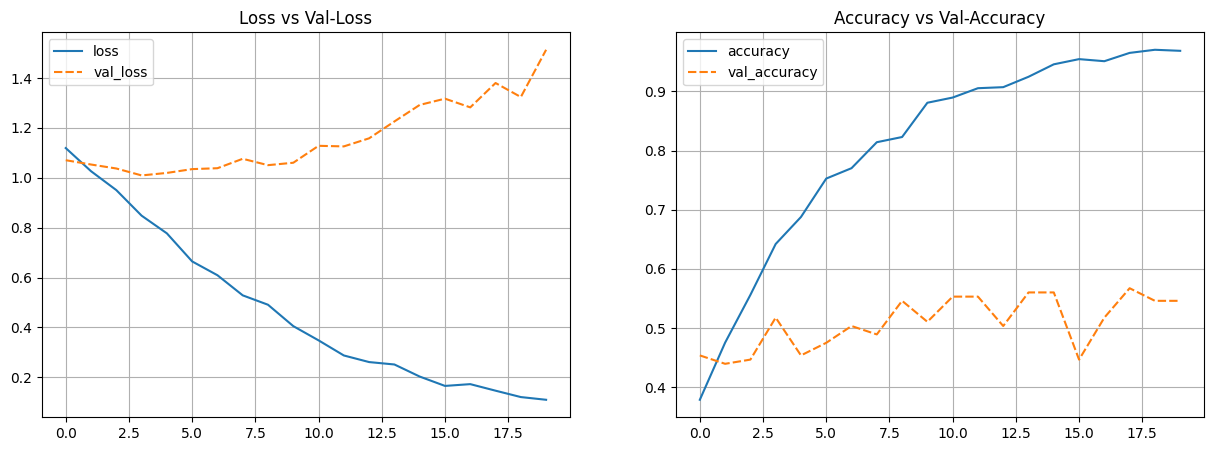

In [70]:
# Plot training results

history_df = pd.DataFrame(history.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=history_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')

plt.subplot(1, 2, 2)
sns.lineplot(data=history_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')
plt.show()

berdasarkan chart, model tanpa augmentasi terjadi overfitting yang mana ini terlihat adanya perbedaan antara akurasi dengan validasi akurasi.

In [71]:
# Check the performance of test-set

## Get the probability
y_pred_prob = model.predict_generator(test_set)

## Get class with maximum probability
y_pred_class = np.argmax(y_pred_prob, axis=-1)

## Display Classification Report
print(classification_report(test_set.classes, y_pred_class, target_names=np.array(list(train_set.class_indices.keys()))))

              precision    recall  f1-score   support

      adidas       0.62      0.39      0.48        38
    converse       0.48      0.74      0.58        38
        nike       0.69      0.58      0.63        38

    accuracy                           0.57       114
   macro avg       0.60      0.57      0.57       114
weighted avg       0.60      0.57      0.57       114



dari performa dalam memprediksi dengan data test, model memiliki akurasi sebesar 57%.

# 7. ANN Improvement (Sequential API/Functional API)

## 7.1. Model Definition

In [62]:
# Create batch generator for train-set, val-set, and test-set

train_datagen_aug = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255.,
    rotation_range=10,       
    zoom_range=0.1,         
    width_shift_range=0.1,   
    height_shift_range=0.1,  
    shear_range=0.1,         
    horizontal_flip=True,    
    vertical_flip=True,     
    brightness_range=[0.8, 1.2], 
    fill_mode='nearest',     
    validation_split=0.2     
)

train_set_aug = train_datagen_aug.flow_from_directory(train_path,
                                                      target_size=(img_height,img_width),
                                                      class_mode='sparse',
                                                      subset='training',
                                                      batch_size=batch_size,
                                                      shuffle=True,
                                                      seed=2)

val_set_aug = train_datagen_aug.flow_from_directory(train_path,
                                                    target_size=(img_height,img_width),
                                                    class_mode='sparse',
                                                    subset='validation',
                                                    batch_size=batch_size,
                                                    shuffle=True,
                                                    seed=2)

test_datagen_aug = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)

test_set_aug = test_datagen_aug.flow_from_directory(test_path,
                                                    target_size=(img_height,img_width),
                                                    class_mode='sparse',
                                                    batch_size=batch_size,
                                                    shuffle=False,
                                                    seed=2)

Found 570 images belonging to 3 classes.
Found 141 images belonging to 3 classes.
Found 114 images belonging to 3 classes.


pada ann improvement, disini digunakan augmentasi dengan parameter rotasi gambar sebesar 10 derajat, zoom range sebesar 10%, geser gambar secara horizontal dan vertikal hingga 10%, transformasi geser hingga 10%, balik gambar secara horizontal dan vertikal, mengatur pencahayaan gambar antara 80% dan 120%.

In [63]:
# Clear session

seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)


model_aug = Sequential()
model_aug.add(Conv2D(64, (3,3), activation='relu', input_shape=(img_height, img_width, 3)))
model_aug.add(MaxPooling2D(2, 2))
model_aug.add(Conv2D(32, (3,3), activation='relu'))
model_aug.add(MaxPooling2D(2, 2))
model_aug.add(Conv2D(16, (3,3), activation='relu'))
model_aug.add(MaxPooling2D(2, 2))
model_aug.add(Flatten())
model_aug.add(Dropout(0.4))
model_aug.add(Dense(128, activation='relu'))
model_aug.add(Dropout(0.3))
model_aug.add(Dense(3, activation='softmax'))  # Output layer

# Compile Model
learning_rate = 0.001
optimizer = Adamax(learning_rate=learning_rate)
model_aug.compile(loss='sparse_categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

digunakan 3 layer konvolusi dengan filter sebanyak 64, 32,dan 16. dilakukan 2 dropout sebesar 40% dan 30%. untuk optimizer digunakan adamax dikarenakan saat menggunakan adam dan nadam tidak dapat menghasilkan akurasi yang baik.

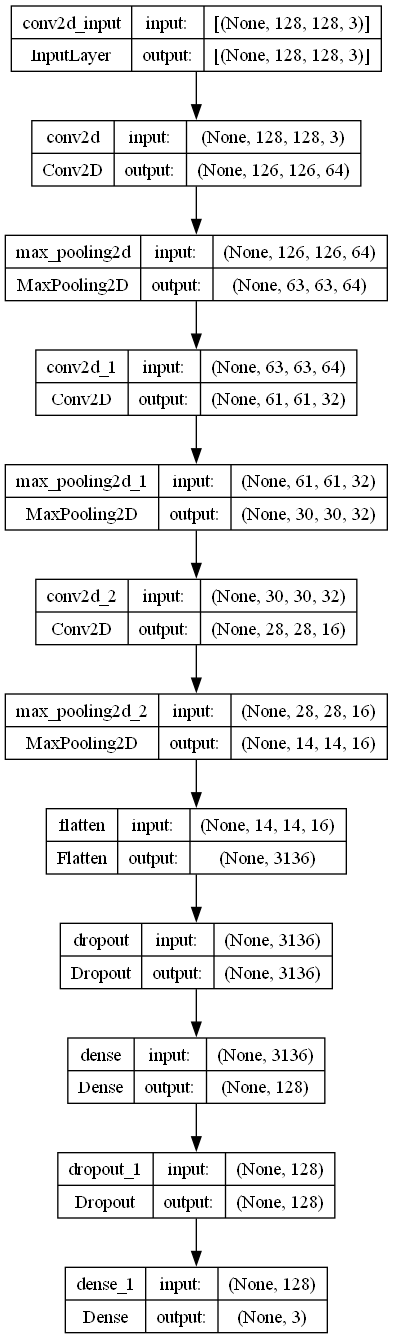

In [64]:
# Plot layers

tf.keras.utils.plot_model(model_aug, show_shapes=True)

## 7.2. Model Training

In [65]:
# Train the model

history_aug = model_aug.fit(train_set_aug, epochs=40, validation_data=val_set_aug, batch_size=batch_size)

Epoch 1/40
36/36 [==============================] - 17s 438ms/step - loss: 1.1102 - accuracy: 0.3404 - val_loss: 1.0954 - val_accuracy: 0.3688
Epoch 2/40
36/36 [==============================] - 9s 244ms/step - loss: 1.0972 - accuracy: 0.3368 - val_loss: 1.0927 - val_accuracy: 0.3333
Epoch 3/40
36/36 [==============================] - 8s 230ms/step - loss: 1.0933 - accuracy: 0.3754 - val_loss: 1.0905 - val_accuracy: 0.3901
Epoch 4/40
36/36 [==============================] - 8s 214ms/step - loss: 1.0869 - accuracy: 0.3439 - val_loss: 1.0923 - val_accuracy: 0.3830
Epoch 5/40
36/36 [==============================] - 9s 238ms/step - loss: 1.0834 - accuracy: 0.3754 - val_loss: 1.0853 - val_accuracy: 0.4043
Epoch 6/40
36/36 [==============================] - 9s 239ms/step - loss: 1.0774 - accuracy: 0.3877 - val_loss: 1.0880 - val_accuracy: 0.3901
Epoch 7/40
36/36 [==============================] - 9s 251ms/step - loss: 1.0676 - accuracy: 0.4333 - val_loss: 1.0819 - val_accuracy: 0.4113
Epoch

digunakan iterasi sebanyak 40 epoch untuk melatih model dengan data yang telah di augmentasi.

## 7.3. Model Evaluation

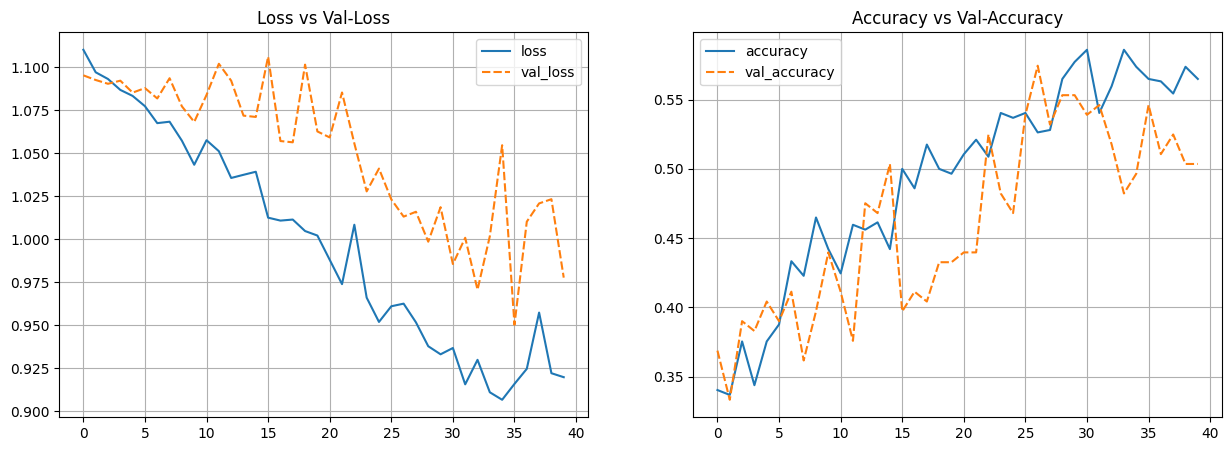

In [66]:
# Plot training results

history_aug_df = pd.DataFrame(history_aug.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=history_aug_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')

plt.subplot(1, 2, 2)
sns.lineplot(data=history_aug_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')
plt.show()

berdasarkan grafik, model goodfit saat berada di epoch 27. dari grafik loss dan val-loss, terlihat ada nya gap antara loss dengan val-loss.

In [67]:
# Check the performance of test-set

## Get the probability
y_pred_prob_aug = model_aug.predict_generator(test_set)

## Get class with maximum probability
y_pred_class_aug = np.argmax(y_pred_prob_aug, axis=-1)

## Display Classification Report
print(classification_report(test_set_aug.classes, y_pred_class_aug, target_names=np.array(list(train_set_aug.class_indices.keys()))))

              precision    recall  f1-score   support

      adidas       0.75      0.32      0.44        38
    converse       0.50      0.95      0.65        38
        nike       0.73      0.50      0.59        38

    accuracy                           0.59       114
   macro avg       0.66      0.59      0.56       114
weighted avg       0.66      0.59      0.56       114



berdasarkan performa akurasi model dalam prediksi data test, akurasi model sebesar 59%.

# 8. Model Saving

In [68]:
model_aug.save('model.h5')

# 9. Kesimpulan

- setelah model dicobakan dengan inference, model masih sering salah dalam mebedakan antara sepatu adidas dan nike. untuk sepatu converse model lebih mudah untuk mengenalinya. 
- dari 3 optimizer, adamax adalah optimizer yang paling optimal untuk dataset ini daripada menggunakan adam dan nadam.
- model menjadi tidak bagus ketika parameter augmentasi yang terlalu ekstrim dikarenakan model sulit untuk membedakan tiap class.
- menggunakan layer yang terlalu banyak dapat mengurangi akurasi model dalam memprediksi suatu class
- apabila kebanyakan epoch, model dapat menjadi overfit 
- tanpa adanya augmentasi, model akan menjadi sangat overfit 